# **Modeling**

#### **Import Packages**

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from tqdm import tqdm

plt.style.use('dark_background')

#### Set Directory

In [3]:
# Change the directory to capstone 2
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

#### **Load the Data**

In [4]:
# Import the small training set
small_train = pd.read_csv('./data/processed/small_train.csv')

# Import the small test set
small_test = pd.read_csv('./data/processed/small_test.csv')

# Import the small training set
big_train = pd.read_csv('./data/processed/big_train.csv')

# Import the small test set
big_test = pd.read_csv('./data/processed/big_test.csv')


Now that I have loaded the datasets, I need to separate out the features (X) from the target variable (y) so that it is easy to run the models. 

In [5]:
# Create the X which is only features in the training data
X_small = small_train.drop(['labels', 'group'], axis = 1)
# Create X small for the test set
X_small_test = small_test.drop(['labels', 'group'], axis = 1)
# Do the same thing for the bigger data set
X_big = big_train.drop(['labels', 'group'], axis = 1)
# Create X big for the test set
X_big_test = big_test.drop(['labels'], axis = 1)
# Create the binary y for the training set.
y_train = np.where(small_train['labels'] == 'normal.', 0, 1)
# Create the binary y for the test set
y_test = np.where(small_test['labels'] == 'normal.', 0, 1)

### **Neural Network**

I wanted to use a gpu for my neural network to speed up the processing significantly. I first tried Keras since that is the simplest API for machine learning in Python. Unfortunately Tensorflow has discontinued support for Windows so I would have to find a lot of older versions of many of the packages in this environment just to get a tensorflow version my GPU can use. 

I didn't give up. If tensorflow wasn't going to use Windows I could still use Linux. I installed Windows Subsystem for Linux (WSL) and tried a remote session with VScode to use tensorflow gpu. After many failed attempts I was able to get my gpu to run the neural networks with tensorflow in the Linux distribution in WSL. Sadly that took significantly longer to run than tensorflow on the cpu in windows. 

My last hope was to try Pytorch on Windows since Pytorch hasn't discontinued Windows support. I don't know how to use Pytorch well but I have all the code from the Keras API that I asked chatGPT to translate into Keras. After wrangling those translations, I found a way to run the neural net with pytorch on the GPU. This did not accelerate the run time as I realized that my batch size for the neural networks had been so low that it had been taking a long time for the neural net to finish fitting the model on the training set. When I set higher batch size number both the CPU and GPU spead up but the CPU was faster because the GPU had to take time to convert the network to its working memory.

Pytorch ended up being far faster as the predictions took significantly less time because of the model.eval() method which can change the model to make it more effiecient in evaluating a test set.

Below I test to see if Pytorch is able to detect my NVIDIA GPU

In [16]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available, using CPU")

GPU is available


My computer has two GPUs. An Intel GPU for videos and graphics in normal computing and an NVIDIA GPU for gaming. The test below is to see which GPU Pytorch is hooked up to.

In [17]:
torch.device("cuda")

device(type='cuda')

First I created cross validation on the model by splitting up the training data into training and test sets so that we can get some feedback from the model while also not contaminating the model by making decisions based on the result of the test set.

Below I used the data from the 12 feature dataset

In [6]:
# Create a train and test data from the 12 feature dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

#### **Small Data**

The first model that I'm going to run is going to use only the training data and using train_test_split to create the test set. Because the official test set contains new values, I want to see how well the data and the model perform when they are only using the type of data that they have been trained for. This in a sense is cross validation because I can still go back and change the model based on this result.

Now that I have some data to test, I can use Pytorch to quickly run through calculations. First I will the define the neural net class, then I can build the model off of it.

In [40]:
# Define the model class Net from the parent class nn.Module
class Net(nn.Module):
    # Initialize the class with 
    def __init__(self, input_dim):
        # Initialize nn.Module with super
        super(Net, self).__init__()
        # Create the first layer of the neural net
        self.fc1 = nn.Linear(input_dim, 12)
        # Create the middle layers of the network that create complexity
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 12)
        self.fc4 = nn.Linear(12, 12)
        self.fc5 = nn.Linear(12, 8)
        self.fc6 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

Now I can create a training function similar to the .fit method in Keras so that everytime I need to use this neural net I can call the function.

In [77]:
# Create a fit function that takes the X-train, y-train, epochs and Batch Size and fits the model
def train_model(X_train, y_train, epochs, batch_sizes, net, multi = False):
    # Create an instance of the model with the correct input_dim
    model = net(X_train.shape[1])

    # Check if the GPU is available and save it to device. If not use the cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move the model over to the device that is available
    model.to(device)

    # Define the loss function
    criterion = nn.BCELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters())

    # Convert the data to torch tensors and move to the GPU
    X_train_tensor = torch.Tensor(X_train.values).float().to(device)
    if multi == False:
        y_train_tensor = torch.Tensor(y_train).float().to(device)
    else: 


    # Training loop
    num_epochs = epochs
    batch_size = batch_sizes
    global losses
    losses = []
    for epoch in range(num_epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(len(X_train_tensor))
        shuffled_X = X_train_tensor[indices]
        shuffled_y = y_train_tensor[indices]
        
        # Set the model to training mode
        model.train()

        # Mini-batch training
        for i in range(0, len(X_train_tensor), batch_size):

            batch_X = shuffled_X[i:i+batch_size]
            batch_y = shuffled_y[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            predicted_labels = (outputs > 0.5).float()
            accuracy = (predicted_labels == batch_y).float().mean()
        

            # Print loss and accuracy
            print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(X_train_tensor)}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}', end = '\r')
        
        losses.append(loss.item()) # type: ignore
    
    return model

In [43]:
nnettrain = train_model(X_train, y_tr, 10, 5000, Net)

The Loss is very low and the accuracy is very high. It shows that I did a good job in my data wrangling and preprocessing to come up with features that present clear patterns for the model to use.

Below is a plot of the loss function after each epoch. 

In [47]:
def loss_plot(loss):
    # Create a plot of the the epics and the losses for each epoch
    plt.plot(range(1,len(loss) + 1), loss);
    # Match the ticks to the epochs
    plt.xticks(np.arange(1, len(loss) + 1));
    # Label the x-axis of the graph
    plt.xlabel("Epoch #");
    # Label the y-axis of the graph
    plt.ylabel("Cost");
    # Title the graph
    plt.title("Model Cost");

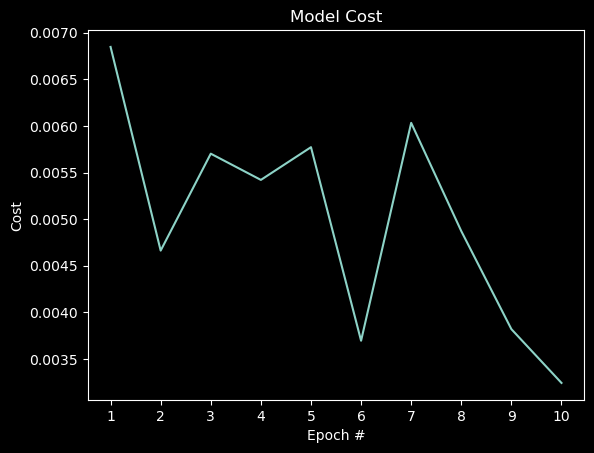

In [44]:
loss_plot(losses)

Because the model was able to train itself so quickly through the different batches in each ep0ch, there is virtually no difference between each epoch which is why the graph contains a bunch of random fluctuations.

Now that I have a trained model on 75% of the data, I can use the last 25% of the data as a cross validational (cv) dataset to test the model but also make improvements if necessary.

In [48]:
# Create a function to evaluate the model
def eval_model(X_test, y_test, model):
    # Set the model to evaluation mode
    model.eval()

    # Move the model and data back to the CPU
    model.to("cpu")
    X_test_tensor = torch.Tensor(X_test.values).float()

    # Make Preds a global variable for the roc graph
    global preds
    # Perform predictions on the test set
    with torch.no_grad():
        preds = model(X_test_tensor)

    # Convert the predictions tensor to a numpy array
    preds = preds.numpy()

    # Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
    preds = np.where(preds < .5, 0, 1)

    # Print the classification report 
    print(classification_report(y_test, preds))

In [49]:
eval_model(X_test, y_te, nnettrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



Wow. The model almost perfect with a very small of intrusions classified as normal. Sometimes I have run it and it has come back perfect but the deep learning process isn't fully deterministic as it is possible for the algorithm to get caught in local minima and not the global minima. While this is not perfect, It has only had 75% of the data to train on. I will use the entire dataset to train for the official test set.

In [16]:
nnetsmall = train_model(X_small, y_train, 10, 5000, Net)

We can save this model as this is from the entire dataset and has very good Accuracy and Loss scores.

In [17]:
# Save the model to the model folder
torch.save(nnetsmall, './models/nnetsmall.pth')

With the entire dataset the loss and Accuracy continue to improve. Now we can predict the official test set

With the saved model we can now see how it performs on the official test set that contains new attack types. Given the incredible performance there is no reason to try hyper-parameter tuning or anything else that could change the result.

In [19]:
# Load the model so that I don't keep having to compute the model
nnetsmall = torch.load('./models/nnetsmall.pth')
# Evaluate the madel with the test set
eval_model(X_small_test, y_test, nnetsmall)

              precision    recall  f1-score   support

           0       0.73      0.83      0.78     60592
           1       0.96      0.93      0.94    250436

    accuracy                           0.91    311028
   macro avg       0.84      0.88      0.86    311028
weighted avg       0.91      0.91      0.91    311028



This appears to be a promising result until I take a closer look. First I will calculate the percentage of observations that are an intrusion.

In [19]:
# Store the unique values and their counts in separate variables
vals, counts = np.unique(y_test, return_counts = True)
# Create value_counts(normalize=True) for np array
prop_counts = counts/len(y_test)
# print the % of observations with no intrusion
print(f'No Intrusion: {round(prop_counts[0]*100, 1)}%')
# print the % of observations with an intrusion
print(f'Intrusion: {round(prop_counts[1]*100,1)}%')

No Intrusion: 19.5%
Intrusion: 80.5%


Above we see that only 19.5% of the test set contains no intrusion so If I had predicted intrusion every time, it would have had a precision of 80 for intrusion, 100 for recall intrusion and zeroes on everything for no intrusion. 

The accuracy scores show that this model is providing important value as they would be 50 if the model guessed intrusion every time. It is also important to note that the test set contains new intrusion types that aren't like the training set. Given the very high training scores, if I had a dataset that didn't have the new intrusion types this model would have been nearly perfect.

To get a better understanding of how well the model performed I can use the Reciever under the Curve metric which measures the True Positive Rate (TPR) against the False Positive Rate (FPR). A ROC area of greater that 0.8 is good and an ROC curve of 0.9 or greater is excellent.

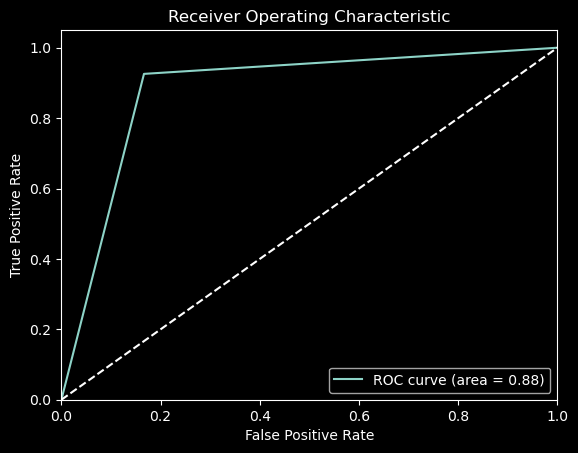

In [20]:
# compute the false positive rate, true positive rate, and threshold for normal observations
fpr, tpr, thresholds = roc_curve(y_test, preds)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc);
# Plot the baseline 50-50 dashed line
plt.plot([0, 1], [0, 1], '--', color = 'w');
# Set the x axis limits
plt.xlim([0.0, 1.0]);
# Set the y axis limits
plt.ylim([0.0, 1.05]);
# Label the x-axis
plt.xlabel('False Positive Rate');
# Label the y-axis
plt.ylabel('True Positive Rate');
# Title the plot
plt.title('Receiver Operating Characteristic');
# Create the legend that has the area under the curve
plt.legend(loc="lower right");
# Show the graph
plt.show();

An ROC curve of .88 is really good but not great. 

These results may not be as good as they seem. The real challenge was to be able to predict unseen attacks in the official test set. Because there is an uneven distribution of attack types some of the new attack types can appear very infrequently. This could mean that the dicrepancy between the cv model and the test model is the new attack types. 

Below I have isolated all the observations in the test set that are new attack types to see how the model fared agains them.

In [21]:
# Create a list of all the new attack types. This list was taken from preprocessing notebook
new_attacks = ['xsnoop.', 'udpstorm.', 'mscan.', 'named.', 'processtable.', 'xlock.', 'snmpgetattack.', 
               'snmpguess.', 'worm.', 'ps.', 'httptunnel.', 'sendmail.', 'saint.', 'mailbomb.', 'apache2.', 'xterm.', 'sqlattack.']
# Create a mask for all values that are in new attacks in the test set
mask = small_test['labels'].isin(new_attacks)
# Use the mask to find all the y-test values that are from new labels
y_test_new = y_test[mask]
# Use the mask to find all the prediction values that are from new labels
preds_new = preds[mask]
# Print the classification report
print(classification_report(y_test_new, preds_new, zero_division = 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.14      0.25     18729

    accuracy                           0.14     18729
   macro avg       0.50      0.07      0.13     18729
weighted avg       1.00      0.14      0.25     18729



This is not the result that I hoped for. Out of all the observations that had new attack types only 14% were correctly classified by the model as an attack. The precision in this table doesn't matter as all the observations are attacks so every time the model predicted an attack it would be correct.

To further investigate, I looked at which attack types the model was best at predicting.

In [36]:
# create a dataframe that is a column of labels that only has the new labels
new_labels = pd.DataFrame(small_test['labels'][mask], columns = ['labels']).reset_index(drop=True)
# create a dataframe that is a column of labels that only has the predictions
pred_df = pd.DataFrame(preds_new, columns = ['pred']).reset_index(drop=True)
# Combine the labels and the predictions for analysis
new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
# Run value counts when the prediction is positive to see which new intrusions the model captures
cni = new_intrusions.loc[new_intrusions['pred'] == 1, 'labels'].value_counts()
# Run value counts when the prediction is negative to see which new intrusions the model doesn't capture
wni = new_intrusions.loc[new_intrusions['pred'] == 0, 'labels'].value_counts()

# Join the right and wrong counts
deep_dive = pd.concat([cni,wni],axis = 1)
# Change the column names to indicate what the counts mean
deep_dive.columns = ["Correct", "Wrong"]
# fill in the NaN values since some attacks had no correct predictions
deep_dive = deep_dive.fillna(0)
# Convert the correct column to the integer type
deep_dive["Correct"] = deep_dive["Correct"].astype(int)
# Create a Net column to show the best and worst new intrusions for the model
deep_dive["net"] = deep_dive["Correct"] - deep_dive["Wrong"]
# Show the deep dive dataframe
deep_dive.sort_values('net', ascending = False)

,Correct,Wrong,net
apache2.,793,1,792
processtable.,739,20,719
saint.,602,134,468
httptunnel.,127,31,96
xlock.,5,4,1
sqlattack.,1,1,0
udpstorm.,1,1,0
xsnoop.,2,2,0
worm.,0,2,-2
ps.,5,11,-6


Some of the new intrusion types must be completely different to any of the intrusion types in the training dataset because the model was not able to notice them at all. I had made two datasets that I wanted to try, one with 12 features and one with 61 features. Hopefull the one with 61 features can give some better insight into distinguishing between the new attack types.

One last test to run on this is to see how the model performs if it is allowed to train on part of the test set and then uses the rest of the test set as its test set. If the model is able to score very highly this way then that means that as long as it has seen the attack it will be able to identify if it is an attack or not.

In [38]:
# Create a train and test data from the 12 feature dataset
X_test_train, X_test_test, y_test_tr, y_test_te = train_test_split(X_small_test, y_test, test_size = .25, random_state = 42)

In [51]:
nnettest = train_model(X_test_train, y_test_tr, 10, 500, Net)

In [52]:
eval_model(X_test_test, y_test_te, nnettest)

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     15035
           1       1.00      0.95      0.97     62722

    accuracy                           0.95     77757
   macro avg       0.90      0.97      0.93     77757
weighted avg       0.96      0.95      0.95     77757



#### **Categorical Models**

As helpful

#### **Big Data**

Now is the chance to use the bigger dataset that is supposed to contain every features that can help distinguish between the intrusion types.

In [72]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_big, small_train['group'], test_size = .25)

# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform the y training data with label encoder
y_group = label_encoder.fit_transform(y_tr)
# Switch over y_group to categorical
y_tr = y_group.astype(object) # type: ignore


In [75]:
# Define the model class Net from the parent class nn.Module
class bigNet(nn.Module):
    # Initialize the class with 
    def __init__(self, input_dim):
        # Initialize nn.Module with super
        super(bigNet, self).__init__()
        # Create the first layer of the neural net
        self.fc1 = nn.Linear(input_dim, 61)
        # Create the middle layers of the network that create complexity
        self.fc2 = nn.Linear(61, 61)
        self.fc3 = nn.Linear(61, 61)
        self.fc4 = nn.Linear(61, 61)
        self.fc5 = nn.Linear(61, 61)
        self.fc6 = nn.Linear(61, 61)
        self.fc7 = nn.Linear(61, 61)
        self.fc8 = nn.Linear(61, 61)
        self.fc9 = nn.Linear(61, 61)
        self.fc10 = nn.Linear(61, 53)
        self.fc11 = nn.Linear(53, 38)
        self.fc12 = nn.Linear(38, 25)
        self.fc13 = nn.Linear(25, 14)
        self.fc14 = nn.Linear(14, 8)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.activation(self.fc8(x))
        x = self.activation(self.fc9(x))
        x = self.activation(self.fc10(x))
        x = self.activation(self.fc11(x))
        x = self.activation(self.fc12(x))
        x = self.activation(self.fc13(x))
        x = self.softmax(self.fc14(x))
        return x

In [76]:
nnetbig = train_model(X_train, y_tr, 10, 5000, bigNet)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [87]:

# Compile the network with the standard optimiizer and loss function
nnetbigcat.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
# Train the model with X_train and the encoded categorical y_group
nnetbigcat.fit(X_train.astype('float32'), y_group, epochs = 2, batch_size = 50)
# Create the predictions. This creates an array that has as many columns as potential predictions
preds = nnetbigcat.predict(X_test)
# Take the highest prediction as the model's prediction
pred = preds.argmax(axis = 1)
# get the intrusions corresponding to the encoder class.
ints = label_encoder.classes_
# Assign each of the predictions to the group that they correspond to
predictions = [ints[i] for i in pred]
# Print out the classification report
print(classification_report(y_te, predictions, zero_division = 0))

              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00        19
       files       0.00      0.00      0.00         3
    internal       1.00      1.00      1.00    703507
        none       1.00      1.00      1.00    242578
       pings       1.00      1.00      1.00    267962
     scripts       0.00      0.00      0.00         4
      sweeps       0.99      0.98      0.98     10290
       warez       0.00      0.00      0.00       245

    accuracy                           1.00   1224608
   macro avg       0.50      0.50      0.50   1224608
weighted avg       1.00      1.00      1.00   1224608



This was slightly more precise than the previous model where the sweeps group was nearly perfect. Now lets see how it performs on the official test set.

In [88]:
# Predict the test dataset with the previous model
preds = nnetbigcat.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))

9720/9720 [==============================] - 14s 1ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00      7574
       files       0.00      0.00      0.00         5
    internal       0.97      1.00      0.99    165217
        none       0.71      0.92      0.80     60592
       pings       0.98      0.92      0.95     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.77      0.68      0.72      4166
       warez       0.00      0.00      0.00      1602

    accuracy                           0.91    311028
   macro avg       0.43      0.44      0.43    311028
weighted avg       0.87      0.91      0.88    311028



Overall the neural networks were amazing at predicting intrusion types that had already happened. If this model was to be used at a security firm than the more diverse set of intrusions that it was allowed to train on the better it would do. Unfortunately there are a set of attacks that without training data is impossible for this model to catch. I don't know if there is a better way to train the model to catch them.

The one thing that I wish I had done better was to get the model to generate more rare events. Given the size of the dataset and the rarety of some of the intrusion types the models just ignored those types and stuck with the more common intrusion types. If I had weighted the model and created some synthetic data with some of the rarer intrusion types that might have helped the model predict all intrusion types.

### **Random Forrest**

The second type of model that I will use is random forrest which is an ensemble method of decision trees. The idea is that since hacking is an inherently human act, the process should follow some sort of decision tree where certain features being elevated or lowered should lead to certain types of intrusions. I did not have enough time to conduct a grid search or random search so I just did the basic version of a Random Forest Classifier.

In [7]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_small, y_train)

# Predict the test set
rf_pred = rf.predict(X_small_test)

# print the classification report
print(classification_report(y_test, rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     60592
           1       0.96      0.91      0.94    250436

    accuracy                           0.90    311028
   macro avg       0.83      0.89      0.85    311028
weighted avg       0.91      0.90      0.90    311028



This is slightly worse than the neural network but it is very close. It could be that If the hyper parameters were correctly tuned that the results would be better. Below is a categorical random forrest.

In [ ]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_small, y_group)

# Predict the test set
rf_pred_group = rf.predict(X_small_test)

In [12]:
# Predict the test dataset with the previous model
preds = rf.predict(X_small_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))

              precision    recall  f1-score   support

 brute force       0.01      0.01      0.01      7574
       files       0.00      0.00      0.00         5
    internal       0.82      0.80      0.81    165217
        none       0.54      0.99      0.70     60592
       pings       0.94      0.28      0.43     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.20      0.50      0.29      4166
       warez       0.00      0.00      0.00      1602

    accuracy                           0.68    311028
   macro avg       0.31      0.32      0.28    311028
weighted avg       0.74      0.68      0.66    311028



This did significantly worse than the neural network. It is important to note that it recalled 99% of all the non intrusion observations but its precision was so low that has much less importance than the recall would indicate.

Below is the same but with the bigger dataset.

In [93]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform y_group
y_group = label_encoder.fit_transform(small_train['group'])
# Transform the y_group variable to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)


# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state= 42)

# Fit the model to the data
rf.fit(X_big, y_group)

# Predict the test dataset with the previous model
preds = rf.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))


              precision    recall  f1-score   support

 brute force       0.05      0.42      0.09      7574
       files       0.00      0.00      0.00         5
    internal       0.53      0.00      0.00    165217
        none       0.21      0.78      0.34     60592
       pings       0.98      0.28      0.43     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.76      0.76      0.76      4166
       warez       1.00      0.13      0.23      1602

    accuracy                           0.23    311028
   macro avg       0.44      0.30      0.23    311028
weighted avg       0.54      0.23      0.17    311028



## **Conclusion**

From these results it is clear that the neural network model is the best model. With more time I could run a lot of hyper paramater tuning and investigate if taking the highest value soft max is the best decision or if maybe sometimes the model hints at something rarer that gets covered up by higher values of more common types. But until then the best model was the big data categorical model. It recalled 92% of all non intrusion observations and 71% precision while also giving valuable insight into the type of intrusion it was. This means that when the model predicted that there was an intrusion there was a 1-(.195*(1-.92)) = 98.4% chance that there was an intrusion.